Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Zero-shot CLIP accuracy on 100 Food-101 validation images: 92.00%


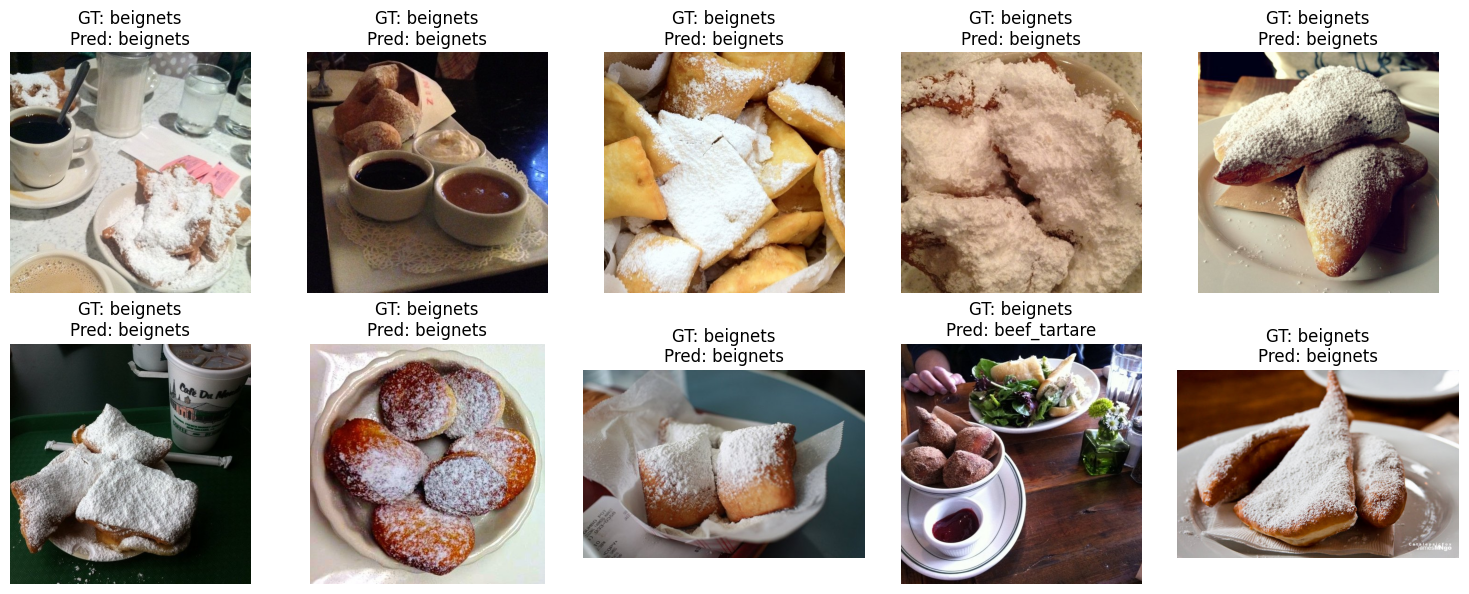

In [1]:
# Zero-Shot Classification on Food-101 using CLIP

from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. Load Zero-Shot CLIP model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

# 2. Load and reduce the Food-101 dataset
food101 = load_dataset("food101")
food101_reduced = {
    "validation": food101["validation"].select(range(100))  # select first 100 samples for quick evaluation
}

# 3. Prepare label mapping from dataset features
id2label = {i: label for i, label in enumerate(food101["train"].features["label"].names)}

# 4. Generate text prompts for each class
text_prompts = [f"a photo of {label}" for label in id2label.values()]

# 5. Zero-shot prediction loop
correct = 0
samples = food101_reduced["validation"]

for sample in samples:
    image = sample["image"]
    if not isinstance(image, Image.Image):
        image = Image.fromarray(np.array(image))

    inputs = clip_processor(text=text_prompts, images=image, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = clip_model(**inputs)
        logits = outputs.logits_per_image
        prediction = logits.argmax().item()

    if prediction == sample["label"]:
        correct += 1

# 6. Report accuracy
accuracy = correct / len(samples)
print(f"Zero-shot CLIP accuracy on {len(samples)} Food-101 validation images: {accuracy:.2%}")

# 7. Show some predictions
def show_predictions(n=10):
    selected = samples.select(range(n))
    fig = plt.figure(figsize=(15, 6))
    for i, sample in enumerate(selected):
        image = sample["image"]
        if not isinstance(image, Image.Image):
            image = Image.fromarray(np.array(image))

        inputs = clip_processor(text=text_prompts, images=image, return_tensors="pt", padding=True)
        with torch.no_grad():
            outputs = clip_model(**inputs)
            logits = outputs.logits_per_image
            prediction = logits.argmax().item()

        fig.add_subplot(2, 5, i+1)
        plt.imshow(image)
        plt.title(f"GT: {id2label[sample['label']]}\nPred: {id2label[prediction]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(n=10)
